<a href="https://colab.research.google.com/github/EshanW313/Deep-Image-Prior/blob/main/DL_Deep_Image_Prior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration 0/5000, Loss: 0.5381828547, PSNR: 2.69 dB
Iteration 1000/5000, Loss: 0.0440292843, PSNR: 13.56 dB
Iteration 2000/5000, Loss: 0.0144951092, PSNR: 18.39 dB
Iteration 3000/5000, Loss: 0.0036450974, PSNR: 24.38 dB
Iteration 4000/5000, Loss: 0.0027811695, PSNR: 25.56 dB
Iteration 5000/5000, Loss: 0.0019055371, PSNR: 27.20 dB


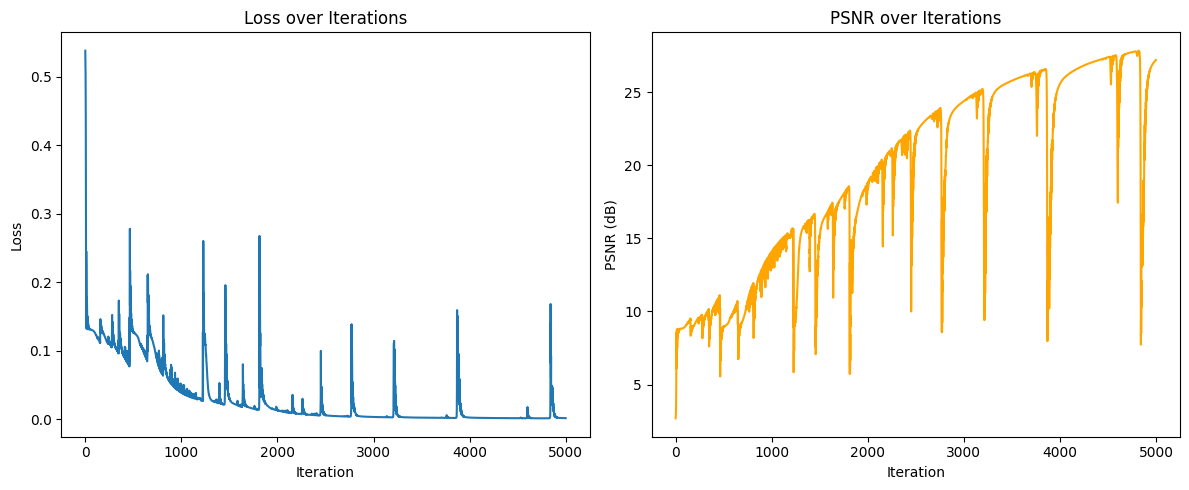

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Simple UNet CNN architecture for DIP
class DIPNet(nn.Module):
  def __init__(self):
    super(DIPNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
    self.conv6 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
    self.conv7 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
    self.conv8 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.relu(self.conv3(x))
    x = self.relu(self.conv4(x))
    x = self.relu(self.conv5(x))
    x = self.relu(self.conv6(x))
    x = self.relu(self.conv7(x))
    x = self.conv8(x)
    return x

# Load and preprocess the image
def load_image(image_path):
  image = Image.open(image_path)
  transform = transforms.Compose([
      transforms.ToTensor()
  ])
  return transform(image).unsqueeze(0)

# Function to calculate PSNR
def calculate_psnr(img1, img2):
  # Ensure both images are on the same device
  img1 = img1.to(img2.device)

  mse = torch.mean((img1 - img2) ** 2)
  if mse == 0:
      return float('inf')
  psnr = 20 * torch.log10(255.0 / torch.sqrt(mse))
  return psnr.item()

# Main function to perform DIP-based restoration
def deep_image_prior(image_path, num_iterations=5000):
  # Load the corrupted image
  corrupted_image = load_image(image_path)

  # Initialize the network and optimizer
  net = DIPNet().cuda()
  optimizer = optim.Adam(net.parameters(), lr=0.0001)

  # Create a random noise input
  input_noise = torch.randn_like(corrupted_image).cuda()

  # Define the loss function - MSE
  criterion = nn.MSELoss()

  # Store Loss and PSNR values
  loss_values = []
  psnr_values = []

  # Training loop
  for i in range(num_iterations + 1):
    optimizer.zero_grad()

    # Forward pass through the network
    output_image = net(input_noise)

    # Compute the loss between output and corrupted image
    loss = criterion(output_image, corrupted_image.cuda())

    # Backpropagation and optimization step
    loss.backward()
    optimizer.step()

    # Print and Save Image
    # if i % 500 == 0:
    loss_values.append(loss.item())
    psnr_value = calculate_psnr(output_image * 255.0, corrupted_image * 255.0)
    psnr_values.append(psnr_value)
    if i % 1000 == 0:
      print(f"Iteration {i}/{num_iterations}, Loss: {loss.item():.10f}, PSNR: {psnr_value:.2f} dB")
      save_image(output_image.cpu().detach(), f"restored_{i}.png")


  # Plotting the results
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(loss_values, label='Loss')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Loss over Iterations')

  plt.subplot(1, 2, 2)
  plt.plot(psnr_values, label='PSNR', color='orange')
  plt.xlabel('Iteration')
  plt.ylabel('PSNR (dB)')
  plt.title('PSNR over Iterations')

  plt.tight_layout()
  plt.show()

# Call main function
deep_image_prior('/content/snail.jpg', 5000)